<a href="https://colab.research.google.com/github/KelllyChen/Interpretable-ML/blob/ML/Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Customer Churn Prediction: Interpretable ML
Dataset can be found here: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code)

This notebook explores different modeling approaches for predicting customer churn.  
We will evaluate **Linear Regression, Logistic Regression, and Generalized Additive Models (GAMs)**.  

### Tasks
1. **Exploratory Data Analysis (EDA)**: Check assumptions and explore relationships.  
2. **Linear Regression**: Treat churn as continuous (0/1).  
3. **Logistic Regression**: Binary classification approach.  
4. **GAM**: Capture non-linear effects.  
5. **Model Comparison**: Evaluate performance, interpretability, and recommend best approach.  


In [60]:
!pip install pygam

In [61]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Explore Data
Here we will first understand the structure of the dataset.

In [62]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [64]:
df.TotalCharges = df.TotalCharges.replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [65]:
df = df.dropna()
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [66]:
# Check unique values especially for categorical columns
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 '

In [67]:
# One hot encoding for categorical coulmns
df.drop("customerID", axis=1, inplace=True)

# Select only categorical columns (object type)
categorical_cols = df.select_dtypes(include='object').columns

# Pick columns with >3 unique values
cols_to_encode = [col for col in categorical_cols if df[col].nunique() >= 3]

print("Columns to one-hot encode:", cols_to_encode)

# Apply one-hot encoding only to these columns
df_encoded = pd.get_dummies(df, columns=cols_to_encode)

# Drop the first dummy automatically
df_encoded = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# Convert bool columns become numeric
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes(include=['bool']).columns})


df_encoded.head()

Columns to one-hot encode: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,Female,0,Yes,No,1,No,Yes,29.85,29.85,No,...,0,0,0,0,0,0,0,0,1,0
1,Male,0,No,No,34,Yes,No,56.95,1889.50,No,...,0,0,0,0,0,1,0,0,0,1
2,Male,0,No,No,2,Yes,Yes,53.85,108.15,Yes,...,0,0,0,0,0,0,0,0,0,1
3,Male,0,No,No,45,No,No,42.30,1840.75,No,...,1,0,0,0,0,1,0,0,0,0
4,Female,0,No,No,2,Yes,Yes,70.70,151.65,Yes,...,0,0,0,0,0,0,0,0,1,0


In [68]:
# Convert binary columns to 0/1
binary_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() == 2]

print("Binary columns:", binary_cols)

for col in binary_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()

Binary columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


## Linear Regression

- EDA before modeling and check assumptions
- Fit the Linear Regression model
- Post-model assumption checks
- Model evaluation

### Assumption 1: Linearity
Here, I create scatter plots of continuous predictors against the response variable to check linearity.

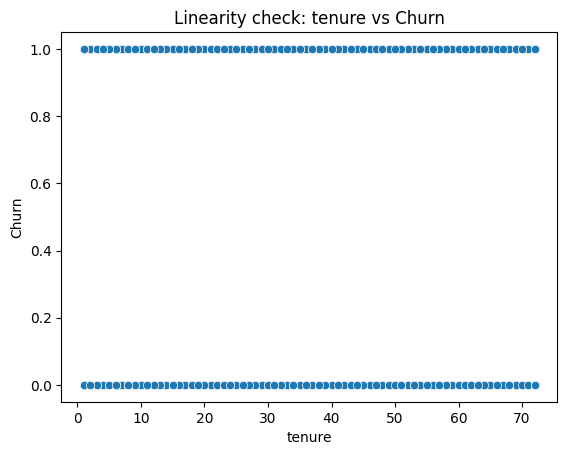

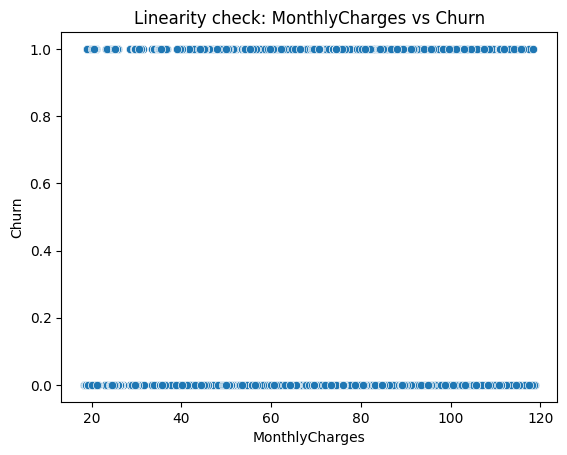

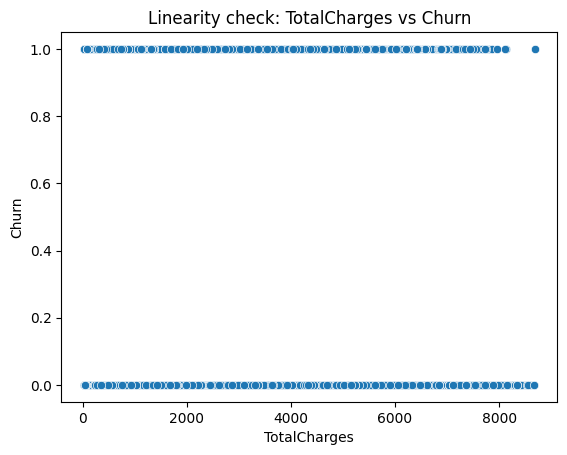

In [69]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']

for col in num_cols:
    sns.scatterplot(x=df_encoded[col], y=df_encoded['Churn'])
    plt.title(f"Linearity check: {col} vs Churn")
    plt.show()

### Assumption 2: No Multicollinearity
- I compute the correlation matrix for all numerical features and identify pairs with correlation coefficients above 0.8, indicating high multicollinearity.
- Additionally, I calculated the Variance Inflation Factor (VIF) for each feature. Features with high VIF values (commonly >10) were considered highly collinear.
- To address multicollinearity, I removed highly correlated features, keeping a set of features with low VIF and low pairwise correlation.

In [70]:
X = df_encoded.drop('Churn', axis=1)
# Compute correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold for high correlation
threshold = 0.8

# Automatically find columns to drop: keep the first column, drop others in each high-corr pair
to_drop = []
for col in upper.columns:
    # Find any row where correlation exceeds threshold
    high_corr_rows = upper.index[upper[col] > threshold].tolist()
    for row in high_corr_rows:
        # Always drop the current column (col) to keep the first (row) in the pair
        if col not in to_drop:
            to_drop.append(col)

# Drop the redundant columns
X.drop(columns=to_drop, inplace=True)

# Recompute correlation matrix on cleaned dataframe
corr_matrix_clean = X.corr().abs()
upper_clean = corr_matrix_clean.where(np.triu(np.ones(corr_matrix_clean.shape), k=1).astype(bool))

# Print remaining high correlations
high_corr_clean = [(col, row, upper_clean.loc[row, col])
                   for col in upper_clean.columns
                   for row in upper_clean.index
                   if upper_clean.loc[row, col] > threshold]

if high_corr_clean:
    print("Remaining highly correlated feature pairs (correlation > 0.8):")
    for pair in high_corr_clean:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No highly correlated features remain.")


No highly correlated features remain.


In [71]:
# Function to calculate VIF
def calculate_vif(df):
    X = sm.add_constant(df)  # add intercept for VIF calculation
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Set VIF threshold
vif_threshold = 10
df_vif = X.copy()

# Iteratively drop high VIF features
while True:
    vif = calculate_vif(df_vif)
    # Exclude 'const' column from consideration
    max_vif = vif.loc[vif['Feature'] != 'const', 'VIF'].max()
    if max_vif < vif_threshold:
        break
    # Drop the feature with the highest VIF
    drop_feature = vif.loc[vif['VIF'] == max_vif, 'Feature'].values[0]
    print(f"Dropping '{drop_feature}' with VIF={max_vif:.2f}")
    df_vif.drop(columns=[drop_feature], inplace=True)

# Final VIF table
final_vif = calculate_vif(df_vif)
print("\nFinal VIFs:")
print(final_vif)


Dropping 'MonthlyCharges' with VIF=863.72

Final VIFs:
                                  Feature        VIF
0                                   const  22.702516
1                                  gender   1.001769
2                           SeniorCitizen   1.153168
3                                 Partner   1.462369
4                              Dependents   1.380811
5                                  tenure   2.827609
6                            PhoneService   1.354768
7                        PaperlessBilling   1.208329
8                       MultipleLines_Yes   1.423682
9             InternetService_Fiber optic   2.005259
10                     InternetService_No   2.692944
11                     OnlineSecurity_Yes   1.415235
12                       OnlineBackup_Yes   1.380823
13                   DeviceProtection_Yes   1.480118
14                        TechSupport_Yes   1.481353
15                        StreamingTV_Yes   1.625973
16                    StreamingMovies_Yes   

### Split train and test set

In [72]:
df_vif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   gender                                 7032 non-null   int64
 1   SeniorCitizen                          7032 non-null   int64
 2   Partner                                7032 non-null   int64
 3   Dependents                             7032 non-null   int64
 4   tenure                                 7032 non-null   int64
 5   PhoneService                           7032 non-null   int64
 6   PaperlessBilling                       7032 non-null   int64
 7   MultipleLines_Yes                      7032 non-null   int64
 8   InternetService_Fiber optic            7032 non-null   int64
 9   InternetService_No                     7032 non-null   int64
 10  OnlineSecurity_Yes                     7032 non-null   int64
 11  OnlineBackup_Yes                   

In [73]:
# y = target column
y = df_encoded['Churn']

# X = all other columns except target
X = df_vif

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Fit Linear Regression Model

- Fit linear regression model
- Evaluate with MSE and R2 score

In [74]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

In [75]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")


Linear Regression:
MSE: 0.15
R2 Score: 0.25
gender: -0.0048
SeniorCitizen: 0.0554
Partner: 0.0061
Dependents: -0.0258
tenure: -0.0047
PhoneService: -0.0588
PaperlessBilling: 0.0362
MultipleLines_Yes: 0.0389
InternetService_Fiber optic: 0.1424
InternetService_No: -0.1237
OnlineSecurity_Yes: -0.0728
OnlineBackup_Yes: -0.0316
DeviceProtection_Yes: -0.0136
TechSupport_Yes: -0.0740
StreamingTV_Yes: 0.0346
StreamingMovies_Yes: 0.0380
Contract_One year: -0.1164
Contract_Two year: -0.0652
PaymentMethod_Credit card (automatic): -0.0097
PaymentMethod_Electronic check: 0.0663
PaymentMethod_Mailed check: -0.0154


### Interpretation
#### Linear Regression

- Sign of coefficient
  - Positive → feature increases the probability of the event (e.g., churn).
  - Negative → feature decreases the probability of the event.
- Magnitude of coefficient
  - Larger absolute value → stronger influence on the outcome.

### Assumption 3. Homoscedasticity
- Plot residuals versus predicted values

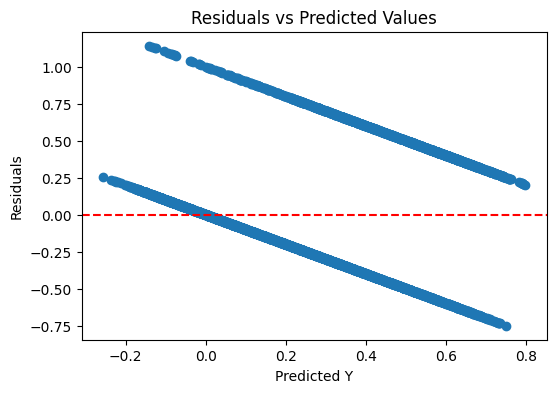

In [76]:
# Predictions on training data
lr_pred_train = lr_model.predict(X_train)

# Residuals
residuals = y_train - lr_pred_train

# Residual plot
plt.figure(figsize=(6,4))
plt.scatter(lr_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Assumption 4: Normality of Residuals

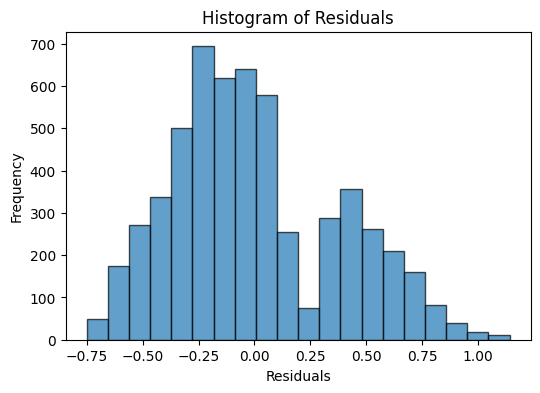

In [77]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Logistic Regression & Generalized Additive Model (GAM)
- Fit both models
- Evaluate with accuracy and f1 score
- Assumptions checking

In [78]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type="logistic", plot_gam=False):

    if model_type == "logistic":
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)

        # Logistic regression interpretation: coefficients and odds ratios
        coef_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": model.coef_[0],
            "Odds_Ratio": np.exp(model.coef_[0])
        }).sort_values("Odds_Ratio", ascending=False)

    elif model_type == "gam":
        model = LogisticGAM()
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)
        preds = model.predict(X_test)

        coef_df = None  # GAM doesn't have simple coefficients

        # Plot GAM partial dependence curves
        if plot_gam:
            # Identify continuous vs binary columns
            continuous_cols = X_train.columns[X_train.nunique() > 2]
            binary_cols = X_train.columns[X_train.nunique() <= 2]

            # Plot continuous features
            for i, col in enumerate(X_train.columns):
                if col in continuous_cols:
                    XX = model.generate_X_grid(term=i)
                    plt.figure()
                    plt.plot(XX[:, i], model.partial_dependence(term=i, X=XX))
                    plt.plot(XX[:, i],
                             model.partial_dependence(term=i, X=XX, width=0.95)[1],
                             c='r', ls='--')  # confidence interval
                    plt.title(f'Partial dependence of {col} (continuous)')
                    plt.xlabel(col)
                    plt.ylabel('Log-odds / effect')
                    plt.show()

            # Plot binary/categorical features as bar charts
            for i, col in enumerate(X_train.columns):
                if col in binary_cols:
                    effects = []
                    for val in sorted(X_train[col].unique()):
                        XX = np.zeros((1, X_train.shape[1]))
                        XX[0, i] = val
                        effect = model.partial_dependence(term=i, X=XX)[0]
                        effects.append(effect)
                    plt.figure()
                    plt.bar([str(v) for v in sorted(X_train[col].unique())], effects)
                    plt.title(f'Effect of {col} (binary/categorical)')
                    plt.ylabel('Log-odds / effect')
                    plt.show()

    else:
        raise ValueError("model_type must be 'logistic' or 'gam'")

    # Evaluation metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    }

    return model, metrics, coef_df


Logistic Regression: {'Accuracy': 0.7910447761194029, 'F1': 0.5714285714285714}

Logistic Regression Coefficients and Odds Ratios:
                                  Feature  Coefficient  Odds_Ratio
8             InternetService_Fiber optic     0.933693    2.543886
15                    StreamingMovies_Yes     0.324322    1.383093
14                        StreamingTV_Yes     0.307469    1.359979
7                       MultipleLines_Yes     0.276265    1.318198
6                        PaperlessBilling     0.270923    1.311174
19         PaymentMethod_Electronic check     0.268207    1.307618
1                           SeniorCitizen     0.263179    1.301060
2                                 Partner     0.053546    1.055006
12                   DeviceProtection_Yes     0.029565    1.030007
20             PaymentMethod_Mailed check    -0.019635    0.980556
0                                  gender    -0.031615    0.968879
4                                  tenure    -0.034967    0.96563

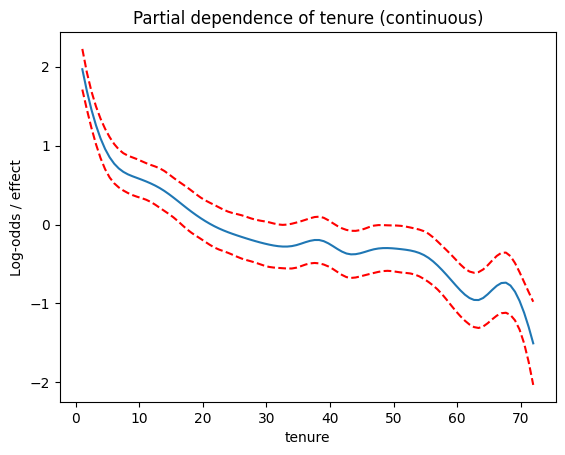

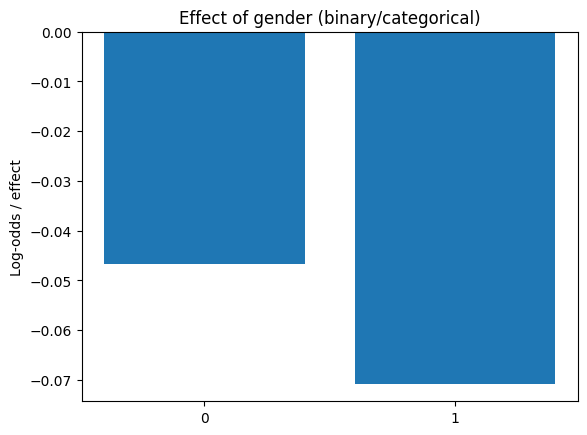

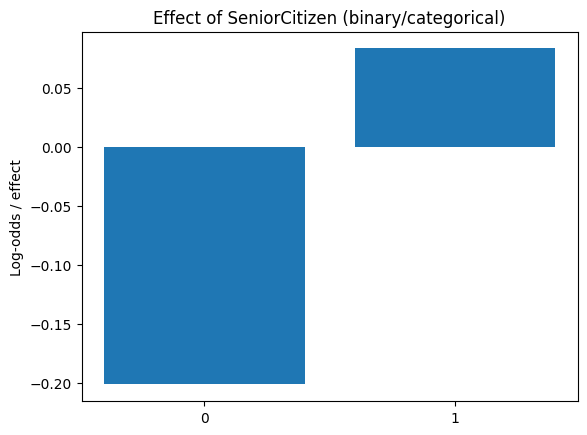

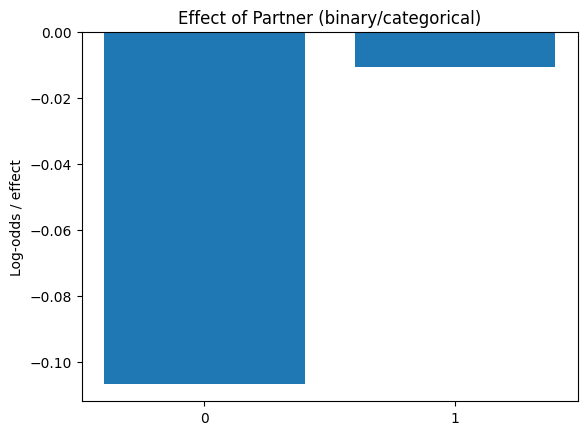

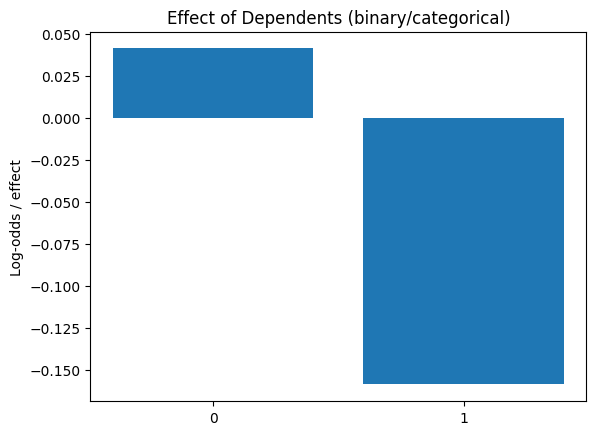

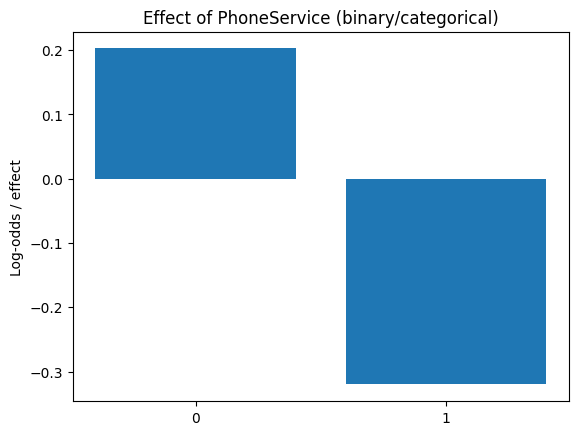

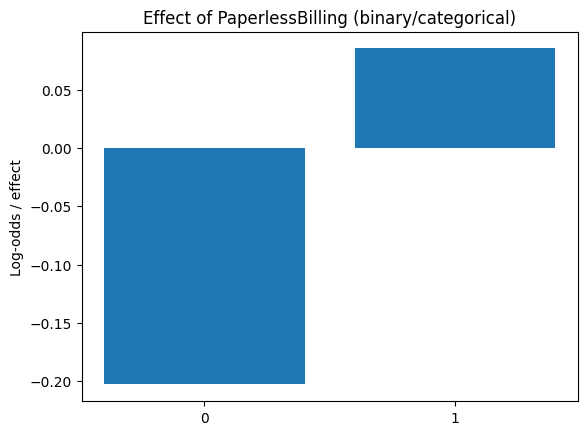

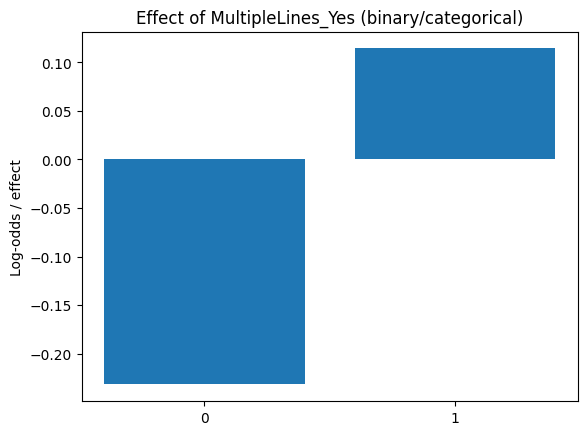

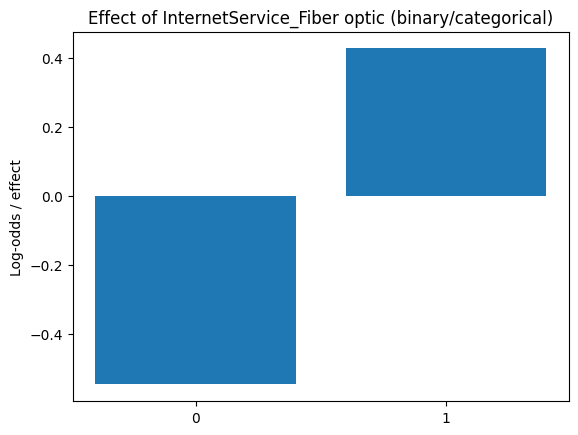

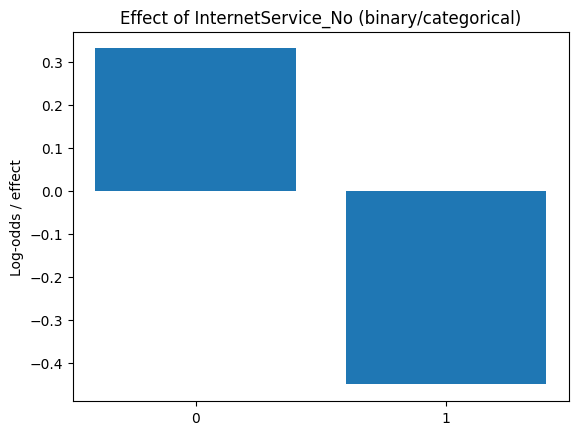

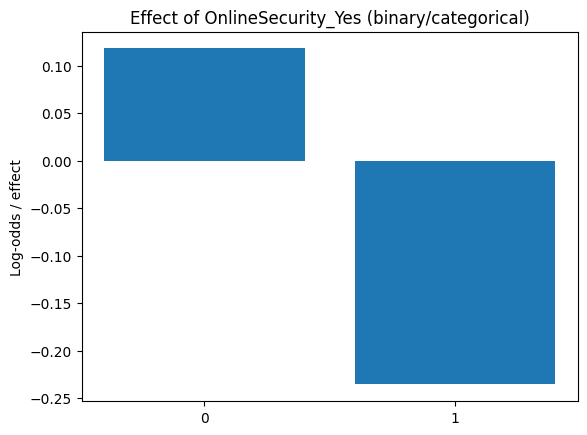

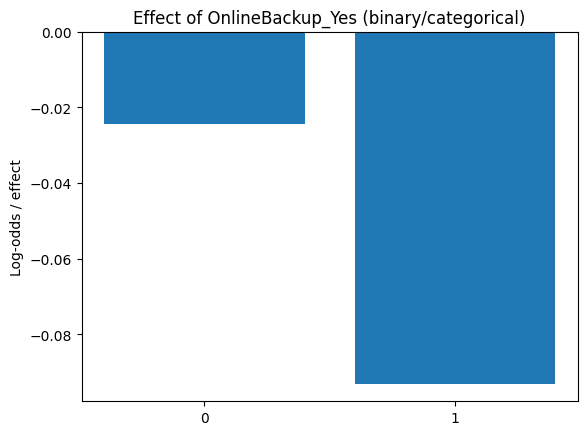

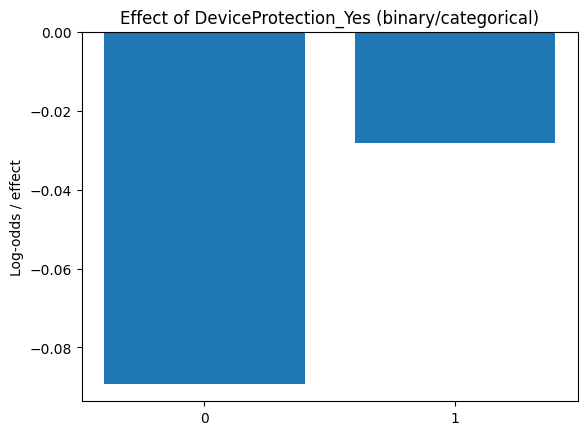

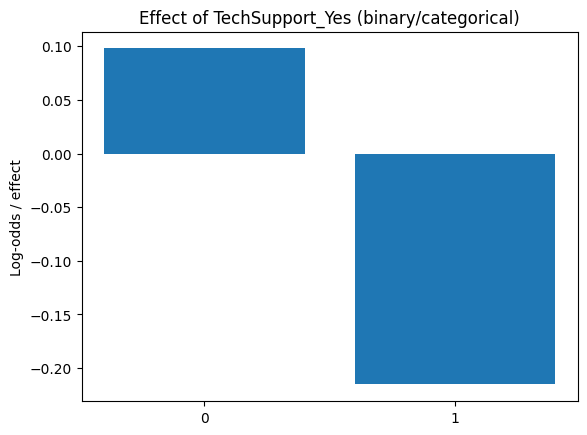

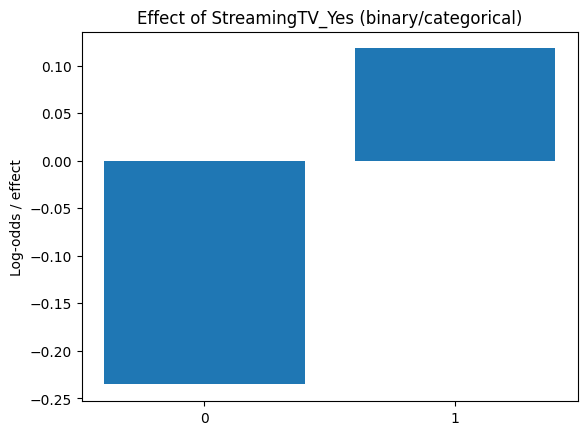

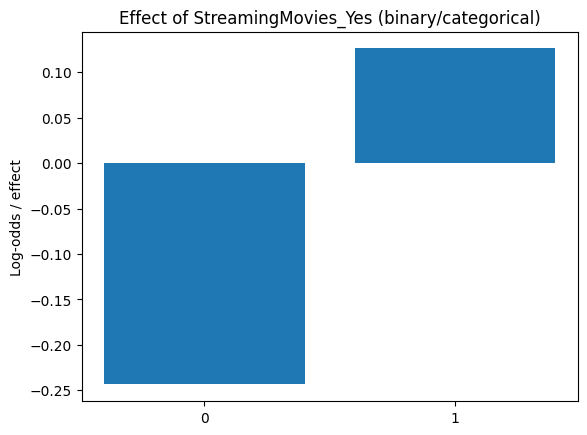

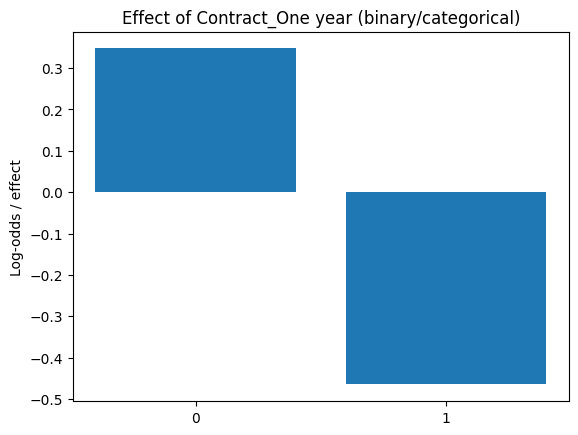

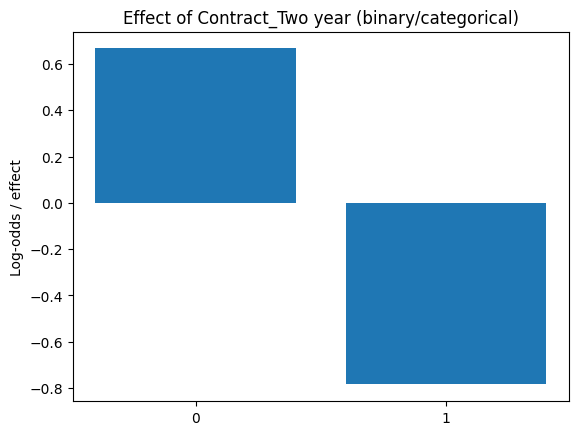

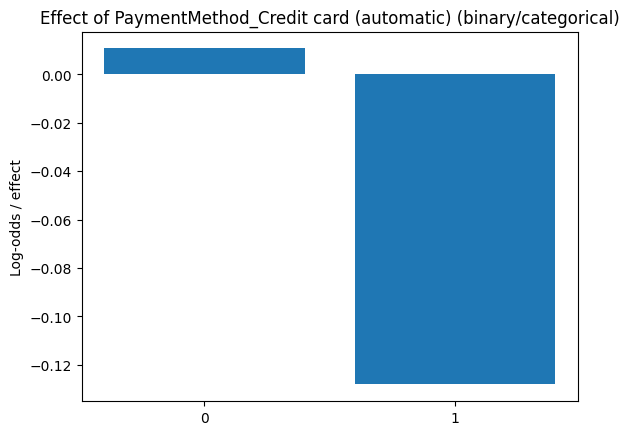

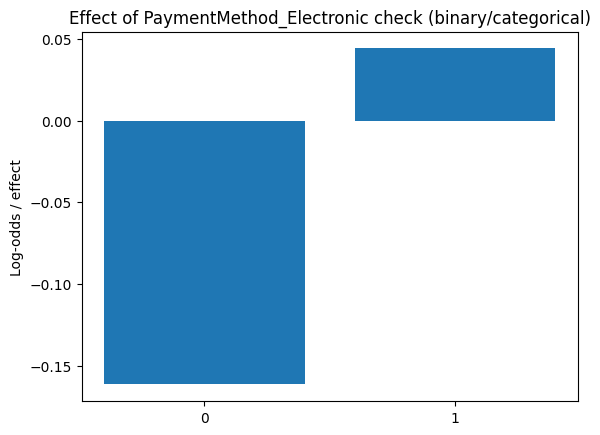

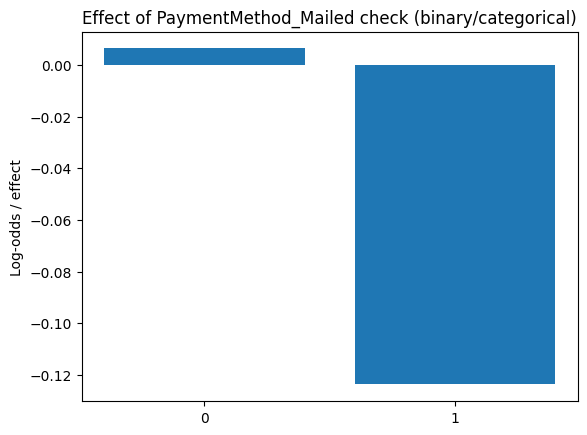

Logistic GAM: {'Accuracy': 0.7967306325515281, 'F1': 0.56797583081571}


In [79]:
log_model, log_metrics, log_coef_df = train_and_evaluate(X_train, y_train, X_test, y_test, model_type="logistic")
print("Logistic Regression:", log_metrics)
print("\nLogistic Regression Coefficients and Odds Ratios:")
print(log_coef_df)


# Logistic GAM with plots
gam_model, gam_metrics, _ = train_and_evaluate(X_train, y_train, X_test, y_test, model_type="gam", plot_gam=True)
print("Logistic GAM:", gam_metrics)

### Interpretation
#### Logistic Regression

- Sign of coefficient
  - Positive → feature increases the probability of the event (e.g., churn).
  - Negative → feature decreases the probability of the event.
- Magnitude of coefficient
  - Larger absolute value → stronger influence on the outcome.
- Odds ratio
  - Odds > 1 = positive
  - Odds < 1 = negative

#### GAM
- Continuous features
  - Increasing curve → higher feature values increase probability.
  - Decreasing curve → higher feature values decrease probability.
  - Flat curve → feature has little effect.
- Binary/categorical features
  - Shown as bar plots instead of smooth curves.
  - Height of bars → effect on log-odds.

### Assumption 1. Linearity
- Logistic regression assumes linear relationship between the logit of the outcome and the predictors
- For categorical predictors encoded as 0/1, the logit is automatically piecewise constant (0 or 1), so the linearity assumption does not apply

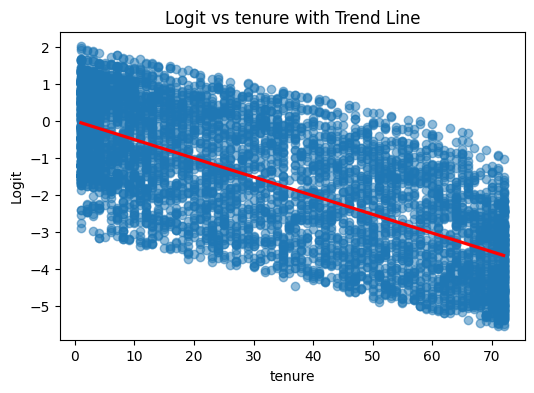

In [80]:
num_cols = ['tenure']

# predicted probability
y_prob = log_model.predict_proba(X_train)[:,1]

# logit
logit = np.log(y_prob / (1 - y_prob))

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x=X_train[col], y=logit, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel(col)
    plt.ylabel('Logit')
    plt.title(f'Logit vs {col} with Trend Line')
    plt.show()

### Assumption 2. No multicollinearity
Assumption has been checked in above cells

### Assumption 3. Absence of perfect separation
- I checked for the absence of perfect separation by plotting bar charts of each categorical predictor against the target to confirm that both outcome classes (0 and 1) are present across all categories.

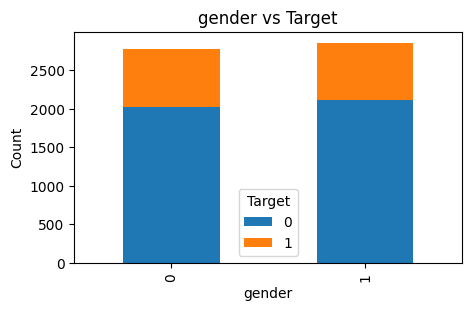

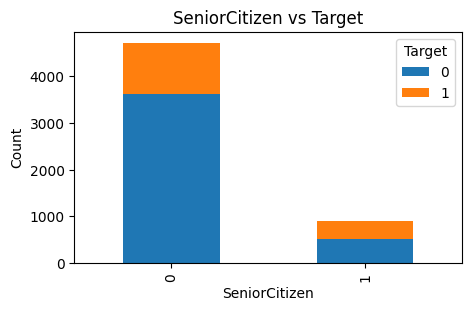

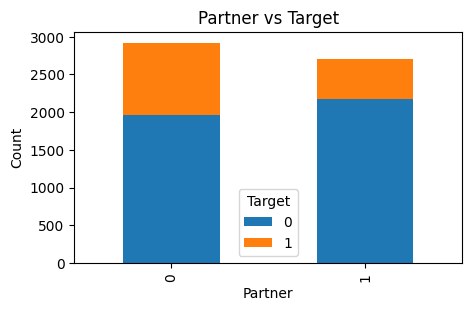

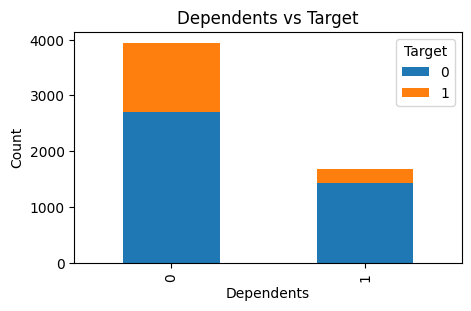

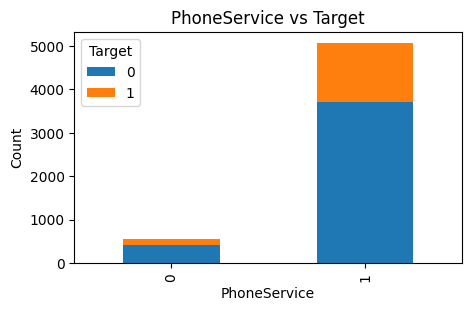

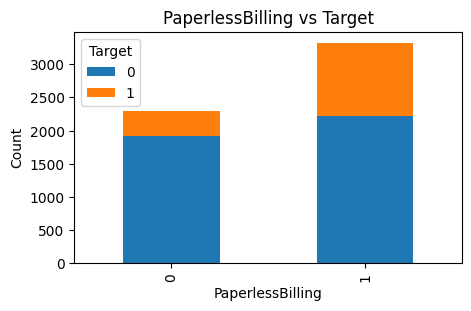

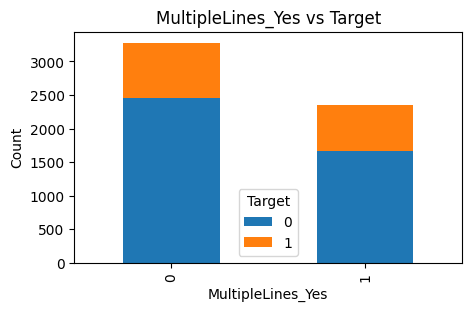

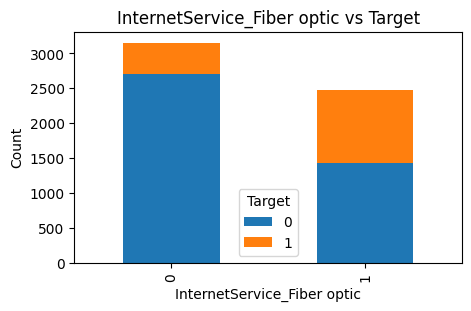

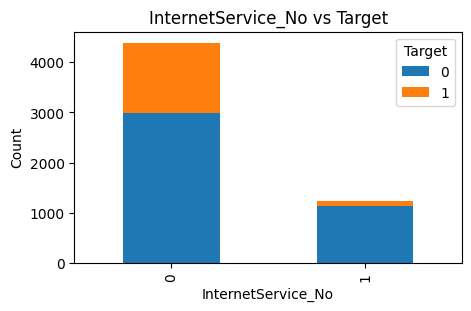

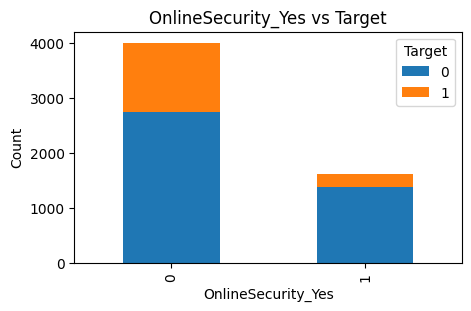

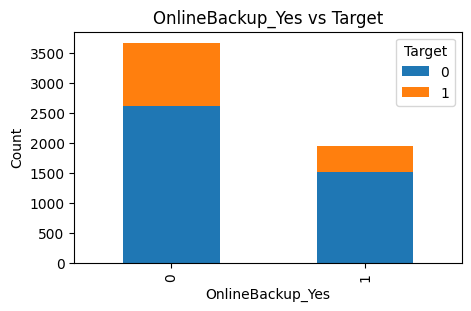

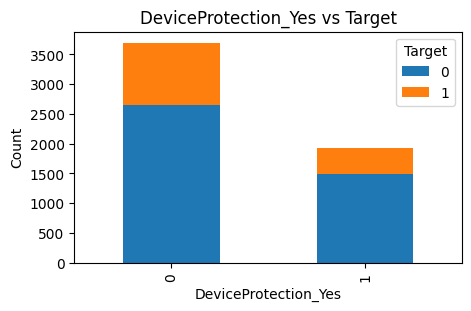

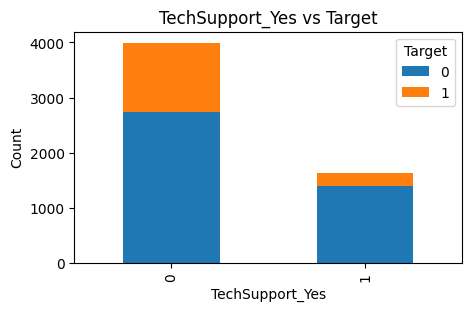

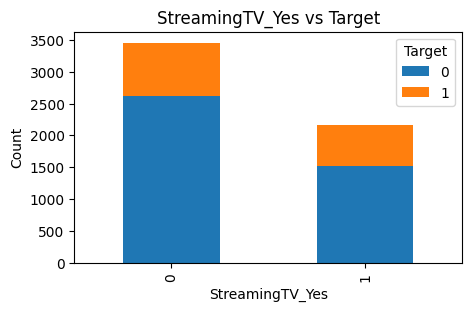

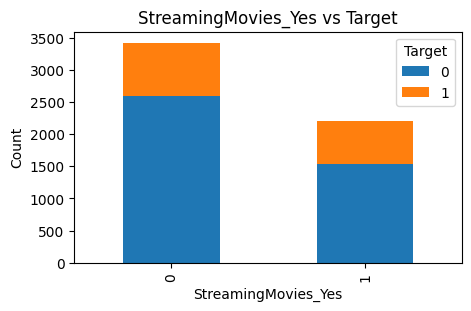

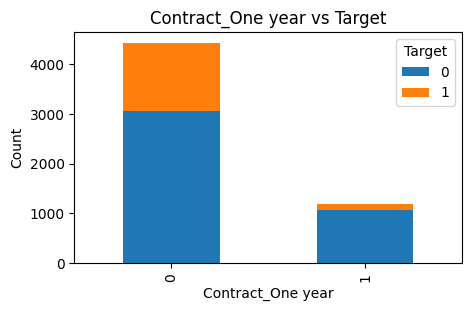

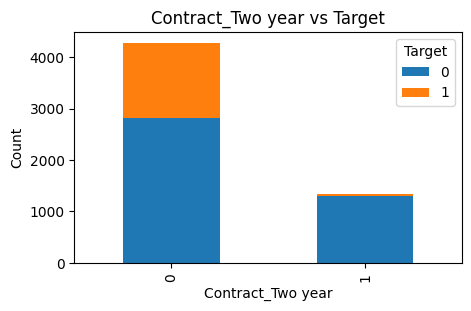

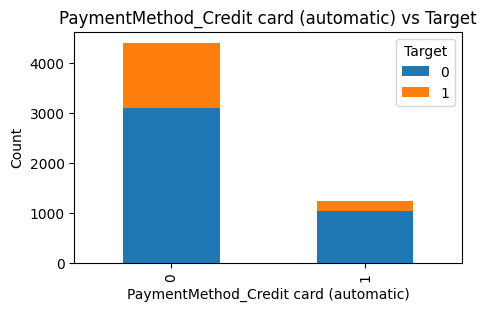

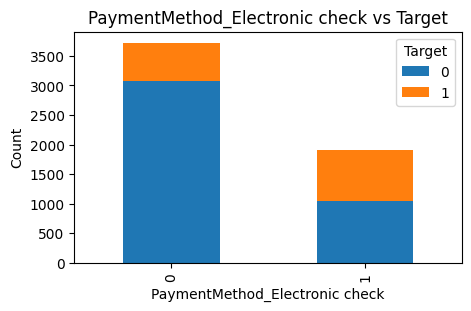

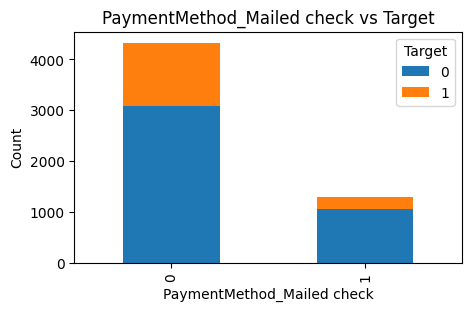

In [81]:
ps_cols = X_train.drop('tenure', axis=1)
for col in ps_cols.columns:
      ct = pd.crosstab(X_train[col], y_train)
      ct.plot(kind='bar', stacked=True, figsize=(5,3))
      plt.title(f"{col} vs Target")
      plt.xlabel(col)
      plt.ylabel("Count")
      plt.legend(title='Target')
      plt.show()

### Assumption 4. Large sample size
- I checked the large sample size assumption by computing the number of predictors, the number of positive and negative cases in the target, and the events per variable (EPV).

In [82]:
def check_logistic_sample_size(X, y, min_epv=10):

    # Number of predictors
    num_predictors = X.shape[1]

    # Count of positive and negative cases
    num_positive = sum(y == 1)
    num_negative = sum(y == 0)

    # Events per variable (EPV)
    epv = num_positive / num_predictors

    # Class balance
    class_balance = y.value_counts(normalize=True)

    print("=== Logistic Regression Sample Size Check ===")
    print(f"Number of predictors: {num_predictors}")
    print(f"Number of positive cases (y=1): {num_positive}")
    print(f"Number of negative cases (y=0): {num_negative}")
    print(f"Events per variable (EPV): {epv:.2f}")
    print("Class balance (proportion):")
    print(class_balance)

    # Warnings
    if epv < min_epv:
        print(f"Warning: EPV ({epv:.2f}) < {min_epv}. Model coefficients may be unstable.")
    if class_balance.min() < 0.05:
        print("Warning: One class <5% of total. Logistic regression estimates may be unreliable.")


In [83]:
check_logistic_sample_size(X_train, y_train)


=== Logistic Regression Sample Size Check ===
Number of predictors: 21
Number of positive cases (y=1): 1495
Number of negative cases (y=0): 4130
Events per variable (EPV): 71.19
Class balance (proportion):
Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64


## Conclusion

### Linear Regression Model
- For the linear regression model, I evaluated key assumptions including **linearity, homoscedasticity, normality of residuals, and absence of multicollinearity**.
- The assumption of **independence** was considered satisfied based on the dataset’s collection methodology.
- To address multicollinearity, I applied both the Variance Inflation Factor (VIF) and the correlation matrix to identify and remove highly correlated features.
- However, based on the diagnostic plots, the assumptions of **linearity**, **homoscedasticity**, and **normality** were not met:
  - The target variable is binary, which violates the foundational assumption of a continuous response in linear regression. The scatterplot also show there's no clear linear relationship between predictors and the response.
  - The Residuals vs. Predicted Values plot reveals a non-constant variance pattern, indicating a violation of homoscedasticity. This assumption requires that residuals exhibit constant variance across all levels of predicted values.
  - The distribution of residuals, as shown in the bar chart, deviates from normality.



### Logistic Regression
- For the logistic regression model, I evaluated assumptions including **linearity, no multicollinearity, independence of observations, absence of perfect separation, and large sample size**.
- **No multicollinearity and independence of observations** were satisfied, the same as linear regression model.
- The scatterplots indicate a linear relationship between the logit of the outcome and the continuous predictors, supporting the assumption of **linearity**.
- Based on the bar charts, each categorical predictor includes both outcome classes (0 and 1) across all categories, confirming the **absence of perfect separation**.
- The dataset meets the **large sample size** requirement, as verified by the Events Per Variable (EPV) calculation.

### Generalized Additive Model (GAM)
- For the generalized additive model, **independence of observations and no perfect separation** were met.

### Model Selection
- Assumptions for linear regression model were not met. Although the model was fitted and evaluation metrics such as Mean Squared Error (MSE) and R² score were obtained, linear regression is not an appropriate choice for this dataset due to its binary target variable and violated assumptions.

- Logistic Regression v.s. Generalized Additive Model(GAM)
  - Based on performance metrics, both models have comparable results. Therefore, the choice between them can be guided by practical considerations such as interpretability and computational efficiency.
  - Logistic regression has better interpretability, making it easier to communicate results to stakeholders. It is also faster to train and predict.
  - Given these advantages, I recommend adopting the logistic regression model for this application.
